# Parte 1. Sistemas multiagentes

## 1. Representación del entorno

El entorno se representa como una retícula rectangular de N x M casillas. En esta retícula hay diferentes categorías que se le asignan a los cuadros:

- Calle donde pueden transitar autos.
- Auto.
- Semáforo.

## 2. Percepciones del entorno

En el modelo los conductores deben tener percepciones del entorno de manera que les permita tomar decisiones.

Las situaciones pueden ser las siguientes:
- Tienen la calle frente a ellos libre.
- Tienen un auto frente a ellos.
- Tienen un semáforo frente a ellos (puede estar en color verde, amarillo o rojo).

## 3. Definir las acciones de los conductores

Para cada situación descrita anteriormente se definen acciones que pueden realizar los conductores.

### La calle enfrente está libre
El auto continua con su velocidad actual.

### Hay un auto enfrente
El auto debe mantener una distancia de 3 metros entre sí mismo y el otro auto, por lo que aquí deberá reducir su velocidad de tal manera que no choque con él, o conservar su misma velocidad si está a una distancia adecuada.

### Hay un semáforo enfrente
Aquí se pueden desprender más situaciones dependiendo del color del semáforo:
#### El semáforo está en rojo
El auto se debe detener (reducir velocidad a 0).

#### El semáforo está en amarillo
El auto debe ir reduciendo su velocidad.

#### El semáforo está en verde
El auto puede continuar moviéndose sin problemas y aumenta su velocidad.

## 4. Simulación con Python

### Importar librerías

In [676]:
import agentpy as ap
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import IPython

### Definición del agente semáforo

In [677]:
class Semaphore(ap.Agent):
    """ 
        Esta clase define a un semáforo.
    """

    def setup(self):
        """ Este método se utiliza para inicializar al semáforo. """
        
        self.step_time = 0.1         # Tiempo que dura cada paso de la simulación

        self.direction = [0, 1]      # Dirección a la que apunta el semáforo

        self.state = 0               # Estado del semáforo 0 = verde, 1 = amarillo, 2 = rojo
        self.state_time = 0          # Tiempo que ha durado el semáforo en el estado actual

        self.green_duration = 50     # Tiempo que dura el semáforo en verde
        self.yellow_duration = 5     # Tiempo que dura el semáforo en amarillo
        self.red_duration = 45       # Tiempo que dura el semáforo en rojo        

    def update(self):
        """ Este método actualiza el estado del semáforo. """
        self.state_time += self.step_time

        if self.state == 0:
            # Caso en el que el semáforo está en verde
            if self.state_time >= self.green_duration:
                self.state = 1
                self.state_time = 0
        elif self.state == 1:
            # Caso en el que el semáforo está en amarillo
            if self.state_time >= self.yellow_duration:
                self.state = 2
                self.state_time = 0
        elif self.state == 2:
            # Caso en el que el semáforo está en rojo
            if self.state_time >= self.red_duration:
                self.state = 0
                self.state_time = 0

    def set_green(self):
        """ Este método forza el semáforo a estar en verde. """        
        self.state = 0
        self.state_time = 0

    def set_yellow(self):
        """ Este método forza el semáforo a estar en amarillo. """        
        self.state = 1
        self.state_time = 0

    def set_red(self):
        """ Este método forza el semáforo a estar en rojo. """        
        self.state = 2
        self.state_time = 0


### Definición del agente auto

In [678]:
class Car(ap.Agent):
    """ 
        Esta clase define a un auto.
    """

    def setup(self):
        """ Este método se utiliza para inicializar un robot limpiador. """
        self.step_time = 0.1         # Tiempo que dura cada paso de la simulación

        self.direction = [1, 0]      # Dirección a la que viaja el auto
        self.speed = 0.0             # Velocidad en metros por segundo
        self.max_speed = 40          # Máxima velocidad en metros por segundo
        self.state = 1               # Car state: 1 = ok, 0 = dead

    def update_position(self):
        """ Este método se utiliza para inicializar la posición del auto. """

        # Verifica si el auto no ha chocado
        if self.state == 0:
            return

         # Actualiza la posición según la velocidad actual
        self.model.avenue.move_by(self, [self.speed*self.direction[0], self.speed*self.direction[1]])

    def update_speed(self):
        
        """ Este método se utiliza para inicializar la velocidad del auto. """

        # Verifica si el auto no ha chocado
        if self.state == 0:
            return
        
        # Obten la distancia más pequeña a uno de los autos que vaya en la misma dirección        
        p = self.model.avenue.positions[self]

        min_car_distance = 1000000
        for car in self.model.cars:
            if car != self:
                # Verifica si el carro va en la misma dirección
                dot_p1 = self.direction[0]*car.direction[0] + self.direction[1]*car.direction[1]                
                
                # Verifica si el carro está atrás o adelante
                p2 = self.model.avenue.positions[car]
                dot_p2 = (p2[0]-p[0])*self.direction[0] + (p2[1]-p[1])*self.direction[1]

                if dot_p1 > 0 and dot_p2 > 0:                     
                    d = math.sqrt((p[0]-p2[0])**2 + (p[1]-p2[1])**2)                    
                    
                    if min_car_distance > d:
                        min_car_distance = d
       
        # Obten la distancia al próximo semáforo
        min_semaphore_distance = 1000000
        semaphore_state = 0
        for semaphore in self.model.semaphores:

            # Verifica si el semáforo apunta hacia el vehículo
            dot_p1 = semaphore.direction[0]*self.direction[0] + semaphore.direction[1]*self.direction[1]
            
            # Verifica si el semáforo está adelante o atrás del vehículo
            p2 = self.model.avenue.positions[semaphore]
            dot_p2 = (p2[0]-p[0])*self.direction[0] + (p2[1]-p[1])*self.direction[1]

            if dot_p1 < 0 and dot_p2 > 0:                            
                d = math.sqrt((p[0]-p2[0])**2 + (p[1]-p2[1])**2)  
                
                if min_semaphore_distance > d:
                    min_semaphore_distance = d
                    semaphore_state = semaphore.state
        
        # Actualiza la velocidad del auto
        if min_car_distance < 2:
            self.speed = 0
            self.state = 1

        elif min_car_distance < 20:
              self.speed = np.maximum(self.speed - 200*self.step_time, 0)

        elif min_car_distance < 50:
              self.speed = np.maximum(self.speed - 80*self.step_time, 0)
                
        elif min_semaphore_distance < 40 and semaphore_state == 1:
            self.speed = np.minimum(self.speed + 5*self.step_time, self.max_speed)

        elif min_semaphore_distance < 50 and semaphore_state == 1:
            self.speed = np.maximum(self.speed - 20*self.step_time, 0)
            
        elif min_semaphore_distance < 100 and semaphore_state == 2:
            self.speed = np.maximum(self.speed - 80*self.step_time, 0)

        else:
            self.speed = np.minimum(self.speed + 5*self.step_time, self.max_speed)

### Definición del modelo de la avenida

In [679]:
class AvenueModel(ap.Model):
    """ Esta clase define un modelo para una avenida simple con semáforo peatonal. """

    def setup(self):
        """ Este método se utiliza para inicializar la avenida con varios autos y semáforos. """
        
        # Inicializa los agentes los autos y los semáforos        
        self.cars = ap.AgentList(self, self.p.cars, Car)
        self.cars.step_time =  self.p.step_time

        self.cars_red = 0
        self.avg_speed = []

        global info
        info = {'cars':[], 'frames': []}

        self.frame_counter = 0
        
        c_north = int(self.p.cars/2)
        c_south = self.p.cars - c_north

        for k in range(c_north):
            self.cars[k].direction = [0,1]

        for k in range(c_south):
            self.cars[k+c_north].direction = [0,-1]

        self.semaphores = ap.AgentList(self,2, Semaphore)
        self.semaphores.step_time =  self.p.step_time
        self.semaphores.green_duration = self.p.green
        self.semaphores.yellow_duration = self.p.yellow
        self.semaphores.red_duration = self.p.red
        self.semaphores[0].direction = [0, 1]
        self.semaphores[1].direction = [0, -1]

        # Inicializa el entorno
        self.avenue = ap.Space(self, shape=[60, self.p.size], torus = True)
                
        # Agrega los semáforos al entorno
        self.avenue.add_agents(self.semaphores, random=True)
        self.avenue.move_to(self.semaphores[0], [10, self.p.size*0.5 + 5])
        self.avenue.move_to(self.semaphores[1], [50, self.p.size*0.5 - 5])

        # Agrega los autos al entorno
        self.avenue.add_agents(self.cars, random=True)
        for k in range(c_north):
            self.avenue.move_to(self.cars[k], [0, 10*(k+1)])
        
        for k in range(c_south):
            self.avenue.move_to(self.cars[k+c_north], [5, self.p.size - (k+1)*10])

        for car in self.cars:
            init_info = {
                'id': car.id - 1,
                'x': 0,
                'z': -10, #Convertir y del modelo a z en la simulacion
                'direction': 0 if car.direction[1] > 0 else 180
            }

            info['cars'].append(init_info)


    def step(self):
        """ Este método se invoca para actualizar el estado de la avenida. """        
        self.semaphores.update()

        self.cars.update_position()
        self.cars.update_speed()

        if (self.t * self.p.step_time) >= 100:
            self.stop()

    def update(self):
        avg_speed = []
        n_cars = 0

        for car in self.cars:
            # dot_prod1 = np.dot(car.direction, self.semaphores[0].direction)
            # dot_prod2 = np.dot(car.direction, self.semaphores[1].direction)
            dist1 = np.linalg.norm(self.avenue.positions[self.semaphores[0]] - self.avenue.positions[car])
            dist2 = np.linalg.norm(self.avenue.positions[self.semaphores[1]] - self.avenue.positions[car])
            # print("Distance to sempahore 1: ", dist1)
            # print("Distance to sempahore 2: ", dist2)

            if dist1 <= 200 or dist2 <= 200:
                avg_speed.append(car.speed)
                if self.semaphores[0].state == 2 and self.semaphores[1].state == 2:
                    n_cars += 1
        
        avg_speed = np.average(avg_speed)

        if np.isnan(avg_speed):
            avg_speed = 0

        self.record('Avg Speed', avg_speed)
        self.record('Cars_red_light', n_cars)
        self.cars_red = n_cars
        self.avg_speed.append(avg_speed)

        frame_info = {
            'frame': self.frame_counter,
            'cars': [
                {
                    'id': car.id - 1,
                    'x': self.avenue.positions[car][0] if self.avenue.positions[car][0] else -5.0,
                    'z': self.avenue.positions[car][1] - 500, #Convertir y del modelo a z en la simulacion
                    'dir': 0 if car.direction[1] > 0 else 180
                } for car in self.cars
            ]
            # 'traffic_lights': [
            #     {
            #         'id': semaphore.id - 3,
            #         'state': semaphore.state
            #     } for semaphore in self.semaphores
            # ]
        }

        info['frames'].append(frame_info)
        self.frame_counter += 1

    def end(self):
        avg_speed = np.average(self.cars.speed)
        self.report('Avg Speed', self.avg_speed)
        self.report('Cars in red light', self.cars_red)
        self.report('Time', self.t * 2)

        # print(type(info['frames']))
        # print("\n info \n", info)

        json_string = json.dumps(info, indent=4)
        with open("data.json", "w") as file:
            file.write(json_string)

### Funciones para visualización del modelo

In [680]:
def animation_plot_single(m, ax):    
    ax.set_title(f"Avenida t={m.t*m.p.step_time:.2f}")
    
    colors = ["green", "yellow", "red"]
    
    pos_s1 = m.avenue.positions[m.semaphores[0]]    
    ax.scatter(*pos_s1, s=20, c=colors[m.semaphores[0].state])
    
    pos_s2 = m.avenue.positions[m.semaphores[1]]    
    ax.scatter(*pos_s2, s=20, c=colors[m.semaphores[1].state])
    
    ax.set_xlim(0, m.avenue.shape[0])
    ax.set_ylim(0, m.avenue.shape[1])    
    
    for car in m.cars:
        pos_c = m.avenue.positions[car]    
        ax.scatter(*pos_c, s=20, c="black")
    
    ax.set_axis_off()
    ax.set_aspect('equal', 'box')
        
def animation_plot(m, p):    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20)) 

### Parámetros de simulación

In [681]:
parameters = {
    'step_time': 0.1,    # Tiempo por cada frame de simulación
    'size': 1000,        # Tamaño en metros de la avenida
    'green': 10,          # Duración de la luz verde
    'yellow': 5,         # Duración de la luz amarilla
    'red': 10,           # Duración de la luz roja
    'cars': 10,          # Número de autos en la simulación
    'steps': 1000,       # Número de pasos de la simulación
}

## Simulación de corrida

In [682]:
model = AvenueModel(parameters)
results = model.run()
results.arrange_variables()

/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Completed: 1000 steps
Run time: 0:00:00.636582
Simulation finished


,t,Avg Speed,Cars_red_light
0,0,0.0,0
1,1,0.0,0
2,2,0.0,0
3,3,0.0,0
4,4,0.0,0
...,...,...,...
996,996,0.0,10
997,997,0.0,10
998,998,0.0,10
999,999,0.0,10


## Visualización

In [683]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# animation = ap.animate(model, fig, ax, animation_plot_single)
# IPython.display.HTML(animation.to_jshtml(fps=20)) 
animation_plot(AvenueModel, parameters)

/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

## Graficación de datos

In [ ]:
data = {"avg_speed": [], "cars_red": [], "time": []}
data["avg_speed"].append(results.reporters['Avg Speed'])
data["time"].append(results.reporters['Time'])

Velocidad promedio

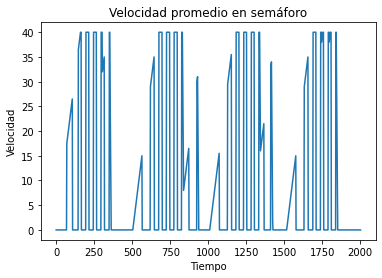

In [ ]:
time = np.arange(0, data['time'][0][0], 2)

x = np.append(time, [2002])
y = data['avg_speed'][0][0]
fig, ax = plt.subplots()
ax.plot(x, y)

plt.xlabel('Tiempo')
plt.ylabel('Velocidad')
plt.title('Velocidad promedio en semáforo')
plt.show()

Número de autos en semáforo rojo

In [ ]:
parameters = [
    {
    'step_time': 0.1,    # Tiempo por cada frame de simulación
    'size': 1000,        # Tamaño en metros de la avenida
    'green': 10,          # Duración de la luz verde
    'yellow': 5,         # Duración de la luz amarilla
    'red': 10,           # Duración de la luz roja
    'cars': 20,          # Número de autos en la simulación
    'steps': 1000,       # Número de pasos de la simulación
    },
    {
    'step_time': 0.1,    # Tiempo por cada frame de simulación
    'size': 1000,        # Tamaño en metros de la avenida
    'green': 10,          # Duración de la luz verde
    'yellow': 5,         # Duración de la luz amarilla
    'red': 10,           # Duración de la luz roja
    'cars': 10,          # Número de autos en la simulación
    'steps': 1000,       # Número de pasos de la simulación
    },
    {
    'step_time': 0.1,    # Tiempo por cada frame de simulación
    'size': 1000,        # Tamaño en metros de la avenida
    'green': 10,          # Duración de la luz verde
    'yellow': 5,         # Duración de la luz amarilla
    'red': 10,           # Duración de la luz roja
    'cars': 30,          # Número de autos en la simulación
    'steps': 1000,       # Número de pasos de la simulación
    },
]

In [ ]:
for p in parameters:
    model = AvenueModel(p)
    results = model.run()
    data["cars_red"].append(results.reporters['Cars in red light'])

/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Completed: 1000 steps
Run time: 0:00:01.909413
Simulation finished
Completed: 1000 steps
Run time: 0:00:01.298046
Simulation finished
Completed: 1000 steps
Run time: 0:00:03.330764
Simulation finished


[0    10
Name: Cars in red light, dtype: int64, 0    10
Name: Cars in red light, dtype: int64, 0    10
Name: Cars in red light, dtype: int64]


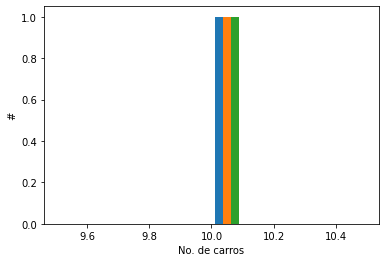

In [ ]:
x = list(range(30))
y = data["cars_red"]

print(data["cars_red"])

fig, ax = plt.subplots()
ax.hist(y) 

ax.set_xlabel('No. de carros')
ax.set_ylabel('#')

plt.show()

## 5. ¿Qué pasaría en la simulación si el tiempo en que aparece la luz amarilla se reduce a 0?

nose xd

In [ ]:
yellow_parameters = {
    'step_time': 0.1,    # Tiempo por cada frame de simulación
    'size': 1000,        # Tamaño en metros de la avenida
    'green': 10,          # Duración de la luz verde
    'yellow': 0,         # Duración de la luz amarilla
    'red': 10,           # Duración de la luz roja
    'cars': 20,          # Número de autos en la simulación
    'steps': 1000,       # Número de pasos de la simulación
}

In [ ]:
yellow_model = AvenueModel(yellow_parameters)
yellow_results = model.run()


Run time: 0:00:00.024193
Simulation finished


In [ ]:
animation_plot(AvenueModel, yellow_parameters) 

/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/nacho/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

Como se puede observar en la simulación, al no tener una transición entre la luz verde y roja, los autos frenan intempestivamente en cuanto el semáforo pasa a rojo, de hecho algunos hasta cruzan en ese momento.

Además, se forman grandes espacios entre los semáforos y el primer auto porque frenan en cuanto detectan el cambio de color.